In [18]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    roc_curve, 
    auc, 
    accuracy_score, 
    f1_score, 
    precision_recall_fscore_support, 
    ConfusionMatrixDisplay, 
    roc_auc_score, 
    log_loss
)
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV, 
    StratifiedShuffleSplit, 
    train_test_split
)
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import LabelBinarizer
import imblearn
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
import lightgbm as lgb
from scipy.sparse import csr_matrix, hstack
from bayes_opt import BayesianOptimization
import time


In [19]:
%%time
file_path = 'GT_IPI.parquet'
df = pd.read_parquet(file_path, engine='pyarrow')

CPU times: total: 18.2 s
Wall time: 4.45 s


In [3]:
indices_df = pd.read_csv('unique_indexes.csv')
indices = indices_df['unique_index'].tolist()
filtered_df = df[df.index.isin(indices)]

df=filtered_df

In [5]:
bool_column = df.apply({0,1}.issuperset)
bool_column_list = bool_column[bool_column == True].index.to_list()
style_counts_by_target = df.groupby('target')['style'].value_counts()
# too many style value in the column style
style_counts_by_target = df.groupby('target')['style'].value_counts()

# Convert the result to a DataFrame
style_counts_by_target_df = style_counts_by_target.to_frame(name='Count').reset_index()

# Initialize an empty list to hold the top 10 terms for each target
top_15_per_target = []

# Calculate the percentage representation and get the top 15 terms for each 'target'
for target in style_counts_by_target_df['target'].unique():
    # Filter the DataFrame for the current target
    target_df = style_counts_by_target_df[style_counts_by_target_df['target'] == target]
    
    # Calculate the total number of terms for the current target
    total_terms = target_df['Count'].sum()
    
    # Calculate the percentage representation of each term
    target_df['Percentage'] = (target_df['Count'] / total_terms) * 100
    
    # Get the top 15 terms
    top_15 = target_df.head(15)
    
    # Append the result to the list
    top_15_per_target.append(top_15)

# Concatenate all top 10 DataFrames into a single DataFrame
combined_top_15 = pd.concat(top_15_per_target)

# Display the unique 'style' values in the combined DataFrame
unique_styles = combined_top_15['style'].unique()
## manually remove title from the list as it is duplicated
#unique_styles = np.delete(unique_styles, np.where(unique_styles == 'title'))
print("Unique 'style' values in the top 15 per target:")
print(unique_styles)
# Transform the 'style' column to 'None' if the current value isn't found in unique_styles
df['style'] = df['style'].apply(lambda x: x if x in unique_styles else 'None')
# Keep a copy of the original 'target' column
original_target = df['target'].copy()

# Apply one-hot encoding to the specified columns
#df_encoded = pd.get_dummies(df, columns=['target', 'begins_with', 'style'], prefix=['target', 'begins_with', 'style'])
df_encoded = pd.get_dummies(df,drop_first = True
                            , columns=['begins_with','para_foll_depth_ind','para_foll_size_ind', 'para_prec_depth_ind', 'para_prec_size_ind', 'style'] + bool_column_list\
                            , prefix=['begins_with','para_foll_depth_ind','para_foll_size_ind', 'para_prec_depth_ind', 'para_prec_size_ind', 'style'] + bool_column_list)
df_encoded = pd.get_dummies(df_encoded
                            , columns=['target']\
                            , prefix=['target'] )

# Add the original 'target' column back to the encoded DataFrame
df_encoded['target'] = original_target

from sklearn.preprocessing import LabelEncoder

# Assuming you have a DataFrame 'df' with a column 'column_name' to encode
le = LabelEncoder()
df_encoded['target_encoded'] = le.fit_transform(df_encoded['target'])


C:\Users\wyatt\AppData\Local\Temp\ipykernel_1696\2028296859.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Percentage'] = (target_df['Count'] / total_terms) * 100
C:\Users\wyatt\AppData\Local\Temp\ipykernel_1696\2028296859.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Percentage'] = (target_df['Count'] / total_terms) * 100
C:\Users\wyatt\AppData\Local\Temp\ipykernel_1696\2028296859.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

Unique 'style' values in the top 15 per target:
['default' 'listparagraph' 'bodytext' 'tableparagraph' 'normal' 'heading2'
 'toc2' 'toc1' 'heading1' 'nospacing' 'heading3' 'normalweb' 'tabletext'
 'toc3' 'listnumber' 'question' 'dvquestion' 'paragraphedeliste'
 'esisquestion' 'title' 'heading4' 'heading10' 'paragraph' 'titre1'
 'dvsubcategory' 'rfpheading3' 'himheading4bodybold' 'heading20']


In [6]:
customers_with_less_than2_csspk = [
    x for x in df_encoded['customer_pk'].unique() 
    if len(df_encoded[df_encoded['customer_pk'] == x]['css_pk'].unique()) < 2
]

filtered_df = df_encoded[~df_encoded['customer_pk'].isin(customers_with_less_than2_csspk)]

In [7]:
from sklearn.model_selection import GroupShuffleSplit

# Lists to store the different train and test dataframes
r_state = [1, 2, 3, 4, 5]
train_df_dict = dict()
test_df_dict = dict()

# Generate 5 different train/test splits
for r in r_state:
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=10*r)
    train_list = []
    test_list = []

    # Perform train-test split within each group
    for i in filtered_df['customer_pk'].unique():
        X = filtered_df.loc[filtered_df['customer_pk'] == i]
        train_index, test_index = next(gss.split(X, groups=X['css_pk']))
        
        # Append the subset data to the respective list
        train_list.append(X.iloc[train_index])
        test_list.append(X.iloc[test_index])

    # Concatenate the lists to create final train and test DataFrames
    train_df_dict[r] = pd.concat(train_list, ignore_index=True)
    test_df_dict[r] = pd.concat(test_list, ignore_index=True)

# Check the length of one of the train and test sets
print(f"Train DataFrame length for r=1: {len(train_df_dict[1])}")
print(f"Test DataFrame length for r=1: {len(test_df_dict[1])}")

Train DataFrame length for r=1: 2438929
Test DataFrame length for r=1: 680281


In [8]:
def df_to_sparse(df, target_col='target_encoded'):
    y = df[target_col].values
    X = df.drop(['target','target_encoded']+columns_to_exclude, axis=1)
    
    binary_cols = X.columns[X.isin([0, 1]).all()]
    binary_sparse = csr_matrix(X[binary_cols].astype(bool).values)
    
    non_binary_cols = X.columns.difference(binary_cols)
    non_binary_dense = X[non_binary_cols].values
    
    X_sparse = hstack([binary_sparse, non_binary_dense]) if len(non_binary_cols) > 0 else binary_sparse
    
    return X_sparse, y

In [9]:

def truncate_dataset(df, target_col='target_encoded', n_samples=100000):
    # Ensure the target column is mutable
    y = np.array(df[target_col].values)
    y.setflags(write=True)
    
    if len(df) > n_samples:
        split = StratifiedShuffleSplit(n_splits=1, test_size=n_samples, random_state=42)
        for _, sample_index in split.split(df, y):
            df_sampled = df.iloc[sample_index]
        return df_sampled
    else:
        return df


In [10]:


# Define the expanded parameter space
param_space_expanded = {
    'num_leaves': (1, 100),
    'max_depth': (3, 20),
    'learning_rate': (0.01, 0.8),
    'n_estimators': (1, 1000),
    'min_child_samples': (10, 100),
    'bagging_fraction': (0.01, 1.0),
    'feature_fraction': (0.01, 1.0),
    'lambda_l1': (0.0, 10.0),
    'lambda_l2': (0.0, 10.0),
    'min_split_gain': (0.0, 1.0),
    'min_child_weight':(0.01,20)
}

# Define the objective function
def lgb_eval(num_leaves, max_depth, learning_rate, n_estimators, min_child_samples,
             bagging_fraction, feature_fraction, lambda_l1, lambda_l2, min_split_gain,  min_child_weight):
    params = {
        'num_leaves': int(num_leaves),
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'min_child_samples': int(min_child_samples),
        'bagging_fraction': bagging_fraction,
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'min_split_gain': min_split_gain,
        'min_child_weight':min_child_weight,
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'device_type': 'gpu',
        'num_class': 4
    }
    logloss_scores = []
    for r in r_state:
        # Data preparation
        train_df = train_df_dict[r]
        test_df = test_df_dict[r]
        X_train = train_df.drop(['target', 'target_encoded'] + columns_to_exclude, axis=1)
        y_train = train_df['target_encoded']
        X_test = test_df.drop(['target', 'target_encoded'] + columns_to_exclude, axis=1)
        y_test = test_df['target_encoded']
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
    
        y_pred = model.predict_proba(X_test)
        logloss = log_loss(y_test, y_pred)
        logloss_scores.append(logloss)
    return np.mean(logloss_scores)

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=lgb_eval,
    pbounds=param_space_expanded,
    random_state=42,
    verbose=2
)

# Perform optimization
optimizer.maximize(init_points=1, n_iter=10)

# Best parameters
best_params = optimizer.max['params']
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['min_child_samples'] = int(best_params['min_child_samples'])

print("Best Parameters:", best_params)
with open('best_paramsm.pkl', 'wb') as pickle_file:
    pickle.dump(best_params, pickle_file)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_ch... | min_sp... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.951207163345817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.951207163345817
[LightGBM] [Warning] lambda_l1 is set=7.319939418114051, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.319939418114051
[LightGBM] [Warning] lambda_l2 is set=5.986584841970366, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.986584841970366
[LightGBM] [Warning] bagging_fraction is set=0.3807947176588889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3807947176588889
[LightGBM] [Warning] feature_fraction is set=0.951207163345817, colsample_bytree=1.0 will be ignored. Current value: featu

In [28]:


# Initialize lists to store reports and features
reports_os = []
features_os = []

# Iterate over the random states
for r in r_state:
    train_set = truncate_dataset(train_df_dict[r])
    test_set = test_df_dict[r]
    
    X_train_sparse, y_train = df_to_sparse(train_set)
    X_test_sparse, y_test = df_to_sparse(test_set)
    
    # Apply SMOTE to balance classes
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_sparse, y_train)
    
    # Initialize XGBoost classifier
    xgb = XGBClassifier    params = {
        'num_leaves': int(num_leaves),
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'min_child_samples': int(min_child_samples),
        'bagging_fraction': bagging_fraction,
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'min_split_gain': min_split_gain,
        'min_child_weight':min_child_weight,
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'device_type': 'gpu',
        'num_class': 4
    }
    
    # Train the model
    xgb.fit(
        X_train_resampled, 
        y_train_resampled,
        verbose=True
    )
    
    # Predict on test set
    test_predictions = xgb.predict(X_test_sparse)
    
    # Feature importance
    feature_importance = xgb.feature_importances_
    feature_names = train_set.drop(['target', 'target_encoded'] + columns_to_exclude, axis=1).columns
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Top 10 most important features:")
    print(feature_importance_df.head(10))
    
    # Print classification report
    report = classification_report(test_set['target_encoded'], test_predictions)
    print(report)
    
    reports_os.append(report)
    features_os.append(feature_importance_df.head(10))

# Print the final averaged classification report
print("Final averaged classification report:")



Top 10 most important features:
                                           feature  importance
42                                begins_with_text    0.113092
43                           para_foll_depth_ind_0    0.079552
44                           para_foll_depth_ind_1    0.059784
14                            lang_pct_list_marker    0.040402
38                  lang_pct_possessive_wh_pronoun    0.029287
64                             style_listparagraph    0.028728
75                                    style_titre1    0.028688
10  lang_pct_preposition_subordinating_conjunction    0.027495
0                                   form_rel_depth    0.023506
62                       style_himheading4bodybold    0.022843
              precision    recall  f1-score   support

           0       0.78      0.81      0.79    343880
           1       0.80      0.79      0.79    313673
           2       0.39      0.32      0.36     12516
           3       0.33      0.12      0.17     10212

   

In [48]:
for res in reports_os:
    print(res)

              precision    recall  f1-score   support

           0       0.78      0.81      0.79    343880
           1       0.80      0.79      0.79    313673
           2       0.39      0.32      0.36     12516
           3       0.33      0.12      0.17     10212

    accuracy                           0.78    680281
   macro avg       0.58      0.51      0.53    680281
weighted avg       0.77      0.78      0.78    680281

              precision    recall  f1-score   support

           0       0.78      0.82      0.80    330279
           1       0.82      0.79      0.81    310293
           2       0.37      0.35      0.36     12745
           3       0.26      0.09      0.13      9174

    accuracy                           0.79    662491
   macro avg       0.56      0.51      0.52    662491
weighted avg       0.79      0.79      0.79    662491

              precision    recall  f1-score   support

           0       0.78      0.81      0.79    333038
           1       0.

In [31]:

# Initialize lists to store precision, recall, and F1-scores
all_precisions = []
all_recalls = []
all_f1s = []
reports_or = []
features_or = []
for r in r_state:
    train_set = train_df_dict[r]
    test_set = test_df_dict[r]
    
    X_train_sparse, y_train = df_to_sparse(train_set)
    X_test_sparse, y_test = df_to_sparse(test_set)
    
    # Apply random oversampling to balance classes
    oversampler = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_sparse, y_train)
    
    # Initialize XGBoost classifier
    xgb = XGBClassifier(
        objective='multi:softprob',
        num_class=4,
        seed=42,
        use_label_encoder=False,
        eval_metric='auc',
        tree_method='hist',
        n_jobs=-1
    )
    
    # Train the model
    xgb.fit(
        X_train_resampled, 
        y_train_resampled,
        verbose=True
    )
    
    # Predict on test set
    test_predictions = xgb.predict(X_test_sparse)
    
    # Feature importance
    feature_importance = xgb.feature_importances_
    feature_names = train_set.drop(['target', 'target_encoded'] + columns_to_exclude, axis=1).columns
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Top 10 most important features:")
    print(feature_importance_df.head(10))
    
    # Print classification report
    report = classification_report(test_set['target_encoded'], test_predictions)
    print(report)

    
    reports_or.append(report)
    features_or.append(feature_importance_df.head(10))

Top 10 most important features:
                           feature  importance
75                    style_titre1    0.142376
43           para_foll_depth_ind_0    0.118863
44           para_foll_depth_ind_1    0.052700
14            lang_pct_list_marker    0.045567
64             style_listparagraph    0.038643
62       style_himheading4bodybold    0.030775
38  lang_pct_possessive_wh_pronoun    0.028459
0                   form_rel_depth    0.019948
8       lang_pct_existential_there    0.017732
65                    style_normal    0.015090
              precision    recall  f1-score   support

           0       0.82      0.68      0.75    343880
           1       0.81      0.79      0.80    313673
           2       0.24      0.67      0.35     12516
           3       0.10      0.52      0.17     10212

    accuracy                           0.73    680281
   macro avg       0.49      0.66      0.51    680281
weighted avg       0.79      0.73      0.75    680281

Top 10 most impo

In [36]:


# Initialize lists to store reports and features
reports_oa = []
features_oa = []

# Iterate over the random states
for r in r_state:
    train_set = truncate_dataset(train_df_dict[r], target_col='target_encoded', n_samples=100000)
    test_set = test_df_dict[r]
    
    X_train_sparse, y_train = df_to_sparse(train_set)
    X_test_sparse, y_test = df_to_sparse(test_set)
    
    # Apply ADASYN to balance classes
    adasyn = ADASYN(random_state=42)
    X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_sparse, y_train)
    
    # Initialize XGBoost classifier
    xgb = XGBClassifier(
        objective='multi:softprob',
        num_class=4,
        seed=42,
        use_label_encoder=False,
        eval_metric='auc',
        tree_method='hist',
        n_jobs=-1
    )
    
    # Train the model
    xgb.fit(
        X_train_resampled, 
        y_train_resampled,
        verbose=True
    )
    
    # Predict on test set
    test_predictions = xgb.predict(X_test_sparse)
    
    # Feature importance
    feature_importance = xgb.feature_importances_
    feature_names = train_set.drop(['target', 'target_encoded'] + columns_to_exclude, axis=1).columns
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Top 10 most important features:")
    print(feature_importance_df.head(10))
    
    # Print classification report
    report = classification_report(test_set['target_encoded'], test_predictions)
    print(report)
    
    reports_oa.append(report)
    features_oa.append(feature_importance_df.head(10))

ValueError: No samples will be generated with the provided ratio settings.

In [16]:

reports = []
features = []
for r in r_state:
    train_set = train_df_dict[r]
    test_set = test_df_dict[r]
    
    X_train_sparse, y_train = df_to_sparse(train_set)
    X_test_sparse, y_test = df_to_sparse(test_set)
    
    
    # Initialize XGBoost classifier
    model = lgb.LGBMClassifier(
        num_leaves = 8,
        max_depth= 8,
        learning_rate= 0.71,
        n_estimators= 672,
        min_child_samples= 30,
        bagging_fraction= 0.045,
        feature_fraction= 0.837,
        lambda_l1= 0.48,
        lambda_l2= 6.33,
        min_split_gain= 0.086,
        min_child_weight=4.11,
        objective= 'multiclass',
        metric= 'multi_logloss',
        boosting_type= 'gbdt',
        n_jobs= -1,
        device_type= 'gpu',
        num_class= 4
        )
    
    # Train the model
    model.fit(
        X_train_sparse, 
        y_train
    )
    
    # Predict on test set
    test_predictions = model.predict(X_test_sparse)
    
    # Feature importance
    feature_importance = model.feature_importances_
    feature_names = train_set.drop(['target', 'target_encoded'] + columns_to_exclude, axis=1).columns
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Top 10 most important features:")
    print(feature_importance_df.head(10))
    
    # Print classification report
    print(classification_report(test_set['target_encoded'], test_predictions))
    
    # Print precision, recall, and F1-score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(test_set['target_encoded'], test_predictions, average=None)
    for i in range(4):
        print(f"Class {i}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-score: {f1[i]:.4f}")
        print()
    
    reports.append(classification_report(test_set['target_encoded'], test_predictions))
    features.append(feature_importance_df.head(10))


[LightGBM] [Warning] feature_fraction is set=0.837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.837
[LightGBM] [Warning] lambda_l1 is set=0.48, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48
[LightGBM] [Warning] lambda_l2 is set=6.33, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.33
[LightGBM] [Warning] bagging_fraction is set=0.045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.045
[LightGBM] [Warning] feature_fraction is set=0.837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.837
[LightGBM] [Warning] lambda_l1 is set=0.48, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48
[LightGBM] [Warning] lambda_l2 is set=6.33, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.33
[LightGBM] [Warning] bagging_fraction is set=0.045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.045
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8572
[L

C:\Users\wyatt\anaconda3\Lib\site-packages\lightgbm\basic.py:1216: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


[LightGBM] [Warning] feature_fraction is set=0.837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.837
[LightGBM] [Warning] lambda_l1 is set=0.48, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48
[LightGBM] [Warning] lambda_l2 is set=6.33, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.33
[LightGBM] [Warning] bagging_fraction is set=0.045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.045
Top 10 most important features:
                         feature  importance
71             style_rfpheading3        1431
73               style_tabletext        1098
75                  style_titre1         994
72          style_tableparagraph         912
100                   is_title_1         887
14          lang_pct_list_marker         838
84               lang_ls_alnum_1         720
83   form_font_colour_mode_ind_1         689
98        para_foll_colour_ind_1         680
0                 form_rel_depth         641
             

C:\Users\wyatt\anaconda3\Lib\site-packages\lightgbm\basic.py:1216: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


[LightGBM] [Warning] feature_fraction is set=0.837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.837
[LightGBM] [Warning] lambda_l1 is set=0.48, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48
[LightGBM] [Warning] lambda_l2 is set=6.33, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.33
[LightGBM] [Warning] bagging_fraction is set=0.045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.045
Top 10 most important features:
                         feature  importance
72          style_tableparagraph        1548
71             style_rfpheading3        1182
75                  style_titre1         895
100                   is_title_1         882
73               style_tabletext         841
91      para_prec_italic_ind_1.0         640
101               style_bullet_1         621
98        para_foll_colour_ind_1         611
14          lang_pct_list_marker         604
83   form_font_colour_mode_ind_1         476
             

C:\Users\wyatt\anaconda3\Lib\site-packages\lightgbm\basic.py:1216: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


[LightGBM] [Warning] feature_fraction is set=0.837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.837
[LightGBM] [Warning] lambda_l1 is set=0.48, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48
[LightGBM] [Warning] lambda_l2 is set=6.33, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.33
[LightGBM] [Warning] bagging_fraction is set=0.045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.045
Top 10 most important features:
                      feature  importance
72       style_tableparagraph        1083
73            style_tabletext        1026
71          style_rfpheading3         965
75               style_titre1         921
100                is_title_1         786
101            style_bullet_1         757
98     para_foll_colour_ind_1         694
91   para_prec_italic_ind_1.0         657
14       lang_pct_list_marker         621
16     lang_pct_noun_singular         592
              precision    recall  f1-score   

C:\Users\wyatt\anaconda3\Lib\site-packages\lightgbm\basic.py:1216: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


[LightGBM] [Warning] feature_fraction is set=0.837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.837
[LightGBM] [Warning] lambda_l1 is set=0.48, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48
[LightGBM] [Warning] lambda_l2 is set=6.33, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.33
[LightGBM] [Warning] bagging_fraction is set=0.045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.045
Top 10 most important features:
                         feature  importance
72          style_tableparagraph        1374
71             style_rfpheading3         996
100                   is_title_1         926
73               style_tabletext         923
75                  style_titre1         886
91      para_prec_italic_ind_1.0         764
101               style_bullet_1         724
90        para_foll_bold_ind_1.0         656
98        para_foll_colour_ind_1         583
83   form_font_colour_mode_ind_1         571
             

C:\Users\wyatt\anaconda3\Lib\site-packages\lightgbm\basic.py:1216: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


[LightGBM] [Warning] feature_fraction is set=0.837, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.837
[LightGBM] [Warning] lambda_l1 is set=0.48, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48
[LightGBM] [Warning] lambda_l2 is set=6.33, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.33
[LightGBM] [Warning] bagging_fraction is set=0.045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.045
Top 10 most important features:
                         feature  importance
72          style_tableparagraph        1368
71             style_rfpheading3        1022
75                  style_titre1         982
73               style_tabletext         934
98        para_foll_colour_ind_1         908
100                   is_title_1         829
83   form_font_colour_mode_ind_1         702
91      para_prec_italic_ind_1.0         644
14          lang_pct_list_marker         619
101               style_bullet_1         558
             

In [17]:
for report in reports:
    print(report)

              precision    recall  f1-score   support

           0       0.79      0.82      0.80    343880
           1       0.81      0.81      0.81    313673
           2       0.42      0.30      0.35     12516
           3       0.31      0.12      0.18     10212

    accuracy                           0.79    680281
   macro avg       0.58      0.51      0.53    680281
weighted avg       0.79      0.79      0.79    680281

              precision    recall  f1-score   support

           0       0.80      0.83      0.81    330279
           1       0.83      0.81      0.82    310293
           2       0.43      0.30      0.35     12745
           3       0.30      0.14      0.20      9174

    accuracy                           0.80    662491
   macro avg       0.59      0.52      0.55    662491
weighted avg       0.80      0.80      0.80    662491

              precision    recall  f1-score   support

           0       0.79      0.82      0.80    333038
           1       0.

In [72]:

reports_t = []
features_t = []
for r in r_state:
    train_set = train_df_dict[r]
    test_set = test_df_dict[r]
    
    X_train_sparse, y_train = df_to_sparse(train_set)
    X_test_sparse, y_test = df_to_sparse(test_set)
    
    
# Initialize XGBoost classifier
    xgb = XGBClassifier(
        n_estimators=693,
        learning_rate=0.8207,
        max_depth=19,
        min_child_weight=32.03,
        gamma=0.2061,
        subsample=0.1765,
        colsample_bytree=0.2263,
        objective='multi:softprob',
        num_class=4,
        scale_pos_weight=1,
        seed=42,
        use_label_encoder=False,
        eval_metric='mlogloss',
        tree_method='hist',
        reg_alpha = 8.765,
        reg_lambda = 8.947,
        n_jobs=-1
    )
    
    # Train the model
    xgb.fit(
        X_train_sparse, 
        y_train,
        verbose=True
    )
    
    # Predict on test set
    test_predictions = xgb.predict(X_test_sparse)
    
    # Feature importance
    feature_importance = xgb.feature_importances_
    feature_names = train_set.drop(['target', 'target_encoded'] + columns_to_exclude, axis=1).columns
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Top 10 most important features:")
    print(feature_importance_df.head(10))
    
    # Print classification report
    print(classification_report(test_set['target_encoded'], test_predictions))
    
    # Print precision, recall, and F1-score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(test_set['target_encoded'], test_predictions, average=None)
    for i in range(4):
        print(f"Class {i}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-score: {f1[i]:.4f}")
        print()
    
    reports_t.append(classification_report(test_set['target_encoded'], test_predictions))
    features_t.append(feature_importance_df.head(10))


C:\Users\wyatt\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:39:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Top 10 most important features:
                                        feature  importance
36                       lang_pct_wh_determiner    0.276369
34  lang_pct_verb_sing_present_non_third_person    0.156337
64                          style_listparagraph    0.079214
35        lang_pct_verb_3rd_person_sing_present    0.042554
11                           lang_pct_adjective    0.030387
28           lang_pct_to_infinitive_preposition    0.022270
65                                 style_normal    0.020799
43                        para_foll_depth_ind_0    0.020268
66                              style_normalweb    0.019791
96                         para_foll_font_ind_1    0.016333
              precision    recall  f1-score   support

           0       0.78      0.80      0.79    343880
           1       0.79      0.79      0.79    313673
           2       0.47      0.32      0.38     12516
           3       0.38      0.13      0.19     10212

    accuracy                        

C:\Users\wyatt\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:47:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Top 10 most important features:
                                        feature  importance
36                       lang_pct_wh_determiner    0.214469
34  lang_pct_verb_sing_present_non_third_person    0.180878
64                          style_listparagraph    0.107905
35        lang_pct_verb_3rd_person_sing_present    0.045423
11                           lang_pct_adjective    0.026589
43                        para_foll_depth_ind_0    0.019603
29                        lang_pct_interjection    0.017503
65                                 style_normal    0.017455
12               lang_pct_adjective_comparative    0.012128
28           lang_pct_to_infinitive_preposition    0.012107
              precision    recall  f1-score   support

           0       0.78      0.82      0.80    330279
           1       0.81      0.79      0.80    310293
           2       0.47      0.32      0.38     12745
           3       0.36      0.13      0.19      9174

    accuracy                        

C:\Users\wyatt\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:54:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Top 10 most important features:
                                        feature  importance
36                       lang_pct_wh_determiner    0.217812
34  lang_pct_verb_sing_present_non_third_person    0.163706
64                          style_listparagraph    0.093155
35        lang_pct_verb_3rd_person_sing_present    0.054190
11                           lang_pct_adjective    0.037533
12               lang_pct_adjective_comparative    0.025388
43                        para_foll_depth_ind_0    0.021446
65                                 style_normal    0.020614
28           lang_pct_to_infinitive_preposition    0.017112
14                         lang_pct_list_marker    0.011837
              precision    recall  f1-score   support

           0       0.78      0.81      0.79    333038
           1       0.80      0.79      0.80    315240
           2       0.49      0.33      0.39     12637
           3       0.39      0.13      0.20      9856

    accuracy                        

C:\Users\wyatt\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:02:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Top 10 most important features:
                                        feature  importance
36                       lang_pct_wh_determiner    0.230171
34  lang_pct_verb_sing_present_non_third_person    0.169251
64                          style_listparagraph    0.097334
35        lang_pct_verb_3rd_person_sing_present    0.047931
11                           lang_pct_adjective    0.024523
43                        para_foll_depth_ind_0    0.021260
65                                 style_normal    0.019032
12               lang_pct_adjective_comparative    0.016317
17                         lang_pct_noun_plural    0.012729
14                         lang_pct_list_marker    0.011588
              precision    recall  f1-score   support

           0       0.79      0.81      0.80    344938
           1       0.80      0.79      0.79    307456
           2       0.47      0.33      0.39     12384
           3       0.36      0.13      0.20      9714

    accuracy                        

C:\Users\wyatt\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:09:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Top 10 most important features:
                                        feature  importance
36                       lang_pct_wh_determiner    0.219836
34  lang_pct_verb_sing_present_non_third_person    0.169672
64                          style_listparagraph    0.091719
35        lang_pct_verb_3rd_person_sing_present    0.051009
11                           lang_pct_adjective    0.049287
43                        para_foll_depth_ind_0    0.022189
65                                 style_normal    0.018054
12               lang_pct_adjective_comparative    0.013160
24                              lang_pct_adverb    0.012423
9                         lang_pct_foreign_word    0.010790
              precision    recall  f1-score   support

           0       0.78      0.82      0.80    338042
           1       0.81      0.79      0.80    318462
           2       0.50      0.33      0.40     13161
           3       0.33      0.12      0.18      9478

    accuracy                        

In [102]:


def visualize_fi(features_list):
    importances_arrays = [df['importance'].values for df in features_list]
    num_features = len(importances_arrays[0]) 
    
    average_importances = np.mean(importances_arrays, axis=0)
    
    feature_names = features_t[0]['feature'].values
    
    indices = np.argsort(average_importances)
    
    plt.figure(figsize=(10, 6))
    plt.title('Average Feature Importances')
    plt.barh(range(len(indices)), average_importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

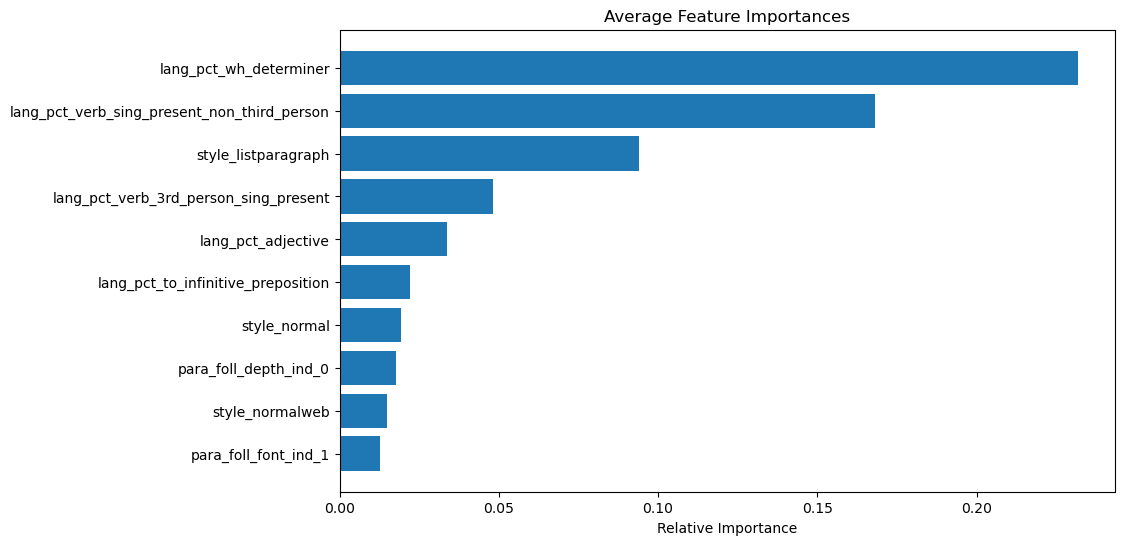

In [103]:
visualize_fi(features_t)

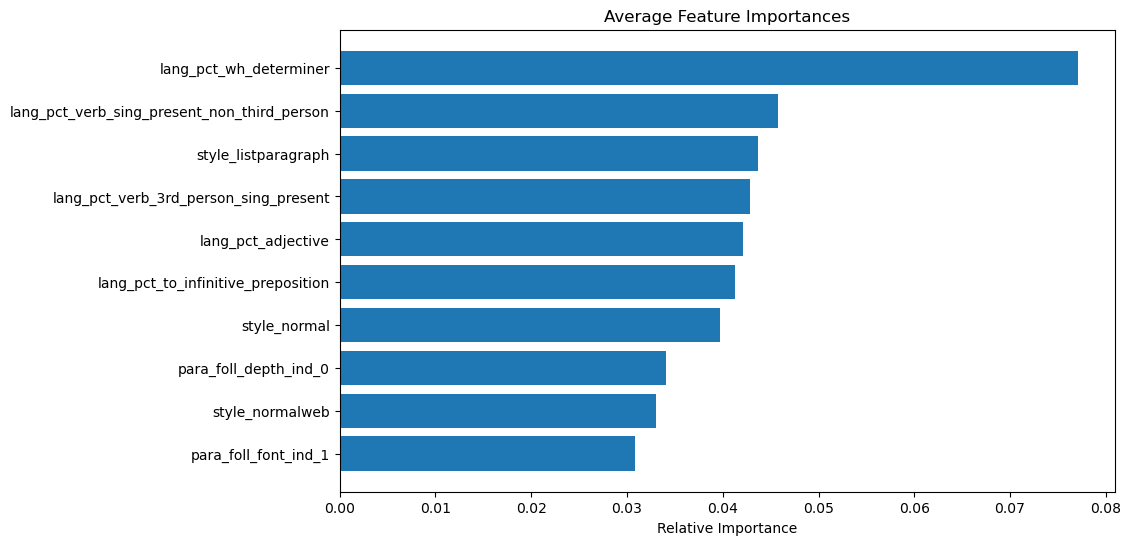

In [104]:
visualize_fi(features_rf)

In [ ]:

reports_rf = []
features_rf = []
for r in r_state:
    train_set = train_df_dict[r]
    test_set = test_df_dict[r]
    
    X_train_sparse, y_train = df_to_sparse(train_set)
    X_test_sparse, y_test = df_to_sparse(test_set)
    
    # Initialize Random Forest classifier
    rf = RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    )
    
    # Train the model
    rf.fit(X_train_sparse, y_train)
    
    # Predict on test set
    test_predictions = rf.predict(X_test_sparse)
    
    # Feature importance
    feature_importance = rf.feature_importances_
    feature_names = train_set.drop(['target', 'target_encoded'] + columns_to_exclude, axis=1).columns
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Top 10 most important features:")
    print(feature_importance_df.head(10))
    
    # Print classification report
    print(classification_report(test_set['target_encoded'], test_predictions))
    
    # Print precision, recall, and F1-score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(test_set['target_encoded'], test_predictions, average=None)
    for i in range(4):
        print(f"Class {i}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-score: {f1[i]:.4f}")
        print()
    
    reports_rf.append(classification_report(test_set['target_encoded'], test_predictions))
    features_rf.append(feature_importance_df.head(10))


In [77]:
for report in reports_rf:
    print(report)
for feature in features_rf:
    print(feature)

              precision    recall  f1-score   support

           0       0.77      0.82      0.80    343880
           1       0.80      0.79      0.79    313673
           2       0.52      0.13      0.21     12516
           3       0.42      0.04      0.07     10212

    accuracy                           0.78    680281
   macro avg       0.63      0.45      0.47    680281
weighted avg       0.77      0.78      0.77    680281

              precision    recall  f1-score   support

           0       0.77      0.84      0.81    330279
           1       0.82      0.79      0.81    310293
           2       0.49      0.14      0.22     12745
           3       0.38      0.04      0.07      9174

    accuracy                           0.79    662491
   macro avg       0.62      0.45      0.47    662491
weighted avg       0.79      0.79      0.79    662491

              precision    recall  f1-score   support

           0       0.77      0.83      0.80    333038
           1       0.

In [69]:


start_time = time.time()

def df_to_sparse(df, target_col='target_encoded'):
    y = df[target_col].values
    X = df.drop(['target', 'target_encoded'] + columns_to_exclude, axis=1)
    
    binary_cols = X.columns[X.isin([0, 1]).all()]
    binary_sparse = csr_matrix(X[binary_cols].astype(bool).values)
    
    non_binary_cols = X.columns.difference(binary_cols)
    non_binary_dense = X[non_binary_cols].values
    
    X_sparse = hstack([binary_sparse, non_binary_dense]) if len(non_binary_cols) > 0 else binary_sparse
    
    return csr_matrix(X_sparse), y

# Define objective function for Bayesian Optimization
def objective(max_depth, learning_rate, n_estimators, min_child_weight, subsample,
              colsample_bytree, reg_alpha, reg_lambda, gamma):
    
    param_space_expanded = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'min_child_weight': int(min_child_weight),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'gamma': gamma,
        'tree_method': 'hist',  # Ensure tree_method is set correctly
        'objective': 'multi:softprob',
        'num_class': 4,
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'n_jobs': -1
    }
    
    # Using a single train-test split instead of multiple folds
    X_train_sparse, y_train = df_to_sparse(train_df)
    X_test_sparse, y_test = df_to_sparse(test_df)
    
    model = XGBClassifier(
        **param_space_expanded
    )
    
    model.fit(
        X_train_sparse, y_train,
        eval_set=[(X_test_sparse, y_test)],
        early_stopping_rounds=10,  # Deprecated warning here
        verbose=False
    )
    
    y_pred = model.predict(X_test_sparse)
    score = f1_score(y_test, y_pred, average='macro')
    
    return score

# Define the search space for Bayesian Optimization
pbounds = {
    'max_depth': (1, 20),
    'learning_rate': (0.1, 1),
    'n_estimators': (1, 1000),
    'min_child_weight': (1, 100),
    'subsample': (0.1, 1.0),
    'colsample_bytree': (0.1, 1.0),
    'reg_alpha': (0.01, 10.0),
    'reg_lambda': (0.01, 10.0),
    'gamma': (0.01, 1.0)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=1,  # Adjust random_state as needed
)

# Perform Bayesian Optimization
optimizer.maximize(
    init_points=5,  # Number of random exploration points
    n_iter=10,      # Number of optimization iterations
)

# Extract the best parameters
best_params = optimizer.max['params']

print("Best trial:")
print("  Value: ", optimizer.max['target'])
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

# Train final model with best parameters
best_params.update({
    'tree_method': 'hist',
    'objective': 'multi:softprob',
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'use_label_encoder': False,
    'n_jobs': -1
})

final_model = XGBClassifier(**best_params)
X_train_sparse, y_train = df_to_sparse(train_df)  # Full train dataset
X_test_sparse, y_test = df_to_sparse(test_df)  # Full test dataset

final_model.fit(X_train_sparse, y_train)

# Predict on test set
test_predictions = final_model.predict(X_test_sparse)

# Classification report and precision, recall, F1-score for each class
print('final below')
print(classification_report(test_df['target_encoded'], test_predictions))
precision, recall, f1, _ = precision_recall_fscore_support(test_df['target_encoded'], test_predictions, average=None)
for i in range(4):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")
    print()

# Feature importance
feature_importance = final_model.feature_importances_
feature_names = train_df.drop(['target', 'target_encoded'] + columns_to_exclude, axis=1).columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 most important features:")
print(feature_importance_df.head(10))

print(f"Total execution time: {time.time() - start_time:.2f} seconds")


|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------


C:\Users\wyatt\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


| 1         | 0.4904    | 0.4753    | 0.7231    | 0.1001    | 6.744     | 15.53     | 93.25     | 1.871     | 3.462     | 0.4571    |


C:\Users\wyatt\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


| 2         | 0.5021    | 0.5849    | 0.425     | 0.7167    | 4.885     | 87.93     | 28.36     | 6.708     | 4.179     | 0.6028    |


C:\Users\wyatt\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


| 3         | 0.5272    | 0.2263    | 0.2061    | 0.8207    | 19.4      | 32.03     | 692.6     | 8.765     | 8.947     | 0.1765    |


C:\Users\wyatt\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


| 4         | 0.5203    | 0.1351    | 0.1781    | 0.8903    | 2.869     | 42.69     | 957.9     | 5.336     | 6.922     | 0.384     |


C:\Users\wyatt\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:


start_time = time.time()

# Assuming train_df and test_df are already loaded
# train_df and test_df should have the target column named 'target'

def df_to_sparse(df, target_col='target_encoded'):
    y = df[target_col].values
    X = df.drop(['target','target_encoded']+columns_to_exclude, axis=1)
    
    binary_cols = X.columns[X.isin([0, 1]).all()]
    binary_sparse = csr_matrix(X[binary_cols].astype(bool).values)
    
    non_binary_cols = X.columns.difference(binary_cols)
    non_binary_dense = X[non_binary_cols].values
    
    X_sparse = hstack([binary_sparse, non_binary_dense]) if len(non_binary_cols) > 0 else binary_sparse
    
    return X_sparse, y

# Convert train and test data to sparse matrices
X_train_sparse, y_train = df_to_sparse(train_df)
X_test_sparse, y_test = df_to_sparse(test_df)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_sparse, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Initialize XGBoost classifier
xgb = XGBClassifier(
    n_estimators=692.6,
    learning_rate=0.8207,
    max_depth=19.4,
    min_child_weight=32.03,
    gamma=0.2061,
    subsample=0.1765,
    colsample_bytree=0.2263,
    objective='multi:softprob',
    num_class=4,
    scale_pos_weight=1,
    seed=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist',
    reg_alpha = 8.765,
    reg_lambda = 8.947,
    n_jobs=-1
)

# Train the model
xgb.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=10,
    verbose=True
)

# Make predictions on validation set
y_pred = xgb.predict(X_val)

# Print classification report
print(classification_report(y_val, y_pred))

# Calculate precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average=None)

# Print results for each class
for i in range(4):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")
    print()

# Predict on test set
test_predictions = xgb.predict(X_test_sparse)

print(f"Total execution time: {time.time() - start_time:.2f} seconds")

# Feature importance
feature_importance = xgb.feature_importances_
feature_names = train_df.drop(['target','target_encoded']+columns_to_exclude, axis=1).columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 most important features:")
print(feature_importance_df.head(10))

print(classification_report(test_df['target_encoded'], test_predictions))
precision, recall, f1, _ = precision_recall_fscore_support(test_df['target_encoded'], test_predictions, average=None)
for i in range(4):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")
    print()

In [ ]:
#import pandas as pd
#from catboost import CatBoostClassifier
#from sklearn.metrics import classification_report, precision_recall_fscore_support
#
#reports = []
#features = []
#
#for r in r_state:
#    train_set = train_df_dict[r]
#    test_set = test_df_dict[r]
#    X_train_sparse, y_train = df_to_sparse(train_set)
#    X_test_sparse, y_test = df_to_sparse(test_set)
#    
#    # Initialize CatBoost classifier
#    catboost = CatBoostClassifier(
#        iterations=1000,  # adjust as needed
#        depth=6,  # adjust as needed
#        learning_rate=0.1,  # adjust as needed
#        loss_function='MultiClass',
#        eval_metric='AUC',
#        random_seed=42,
#        verbose=True
#    )
#    
#    # Train the model
#    catboost.fit(
#        X_train_sparse,
#        y_train,
#        verbose_eval=True
#    )
#    
#    # Predict on test set
#    test_predictions = catboost.predict(X_test_sparse)
#    
#    # Feature importance
#    feature_importance = catboost.get_feature_importance()
#    feature_names = train_set.drop(['target', 'target_encoded'] + columns_to_exclude, axis=1).columns
#    feature_importance_df = pd.DataFrame({
#        'feature': feature_names,
#        'importance': feature_importance
#    }).sort_values('importance', ascending=False)
#    
#    print("Top 10 most important features:")
#    print(feature_importance_df.head(10))
#    
#    # Print classification report
#    print(classification_report(test_set['target_encoded'], test_predictions))
#    precision, recall, f1, _ = precision_recall_fscore_support(test_set['target_encoded'], test_predictions, average=None)
#    for i in range(4):
#        print(f"Class {i}:")
#        print(f"  Precision: {precision[i]:.4f}")
#        print(f"  Recall: {recall[i]:.4f}")
#        print(f"  F1-score: {f1[i]:.4f}")
#        print()
#    
#    reports.append(classification_report(test_set['target_encoded'], test_predictions))
#    features.append(feature_importance_df.head(10))


In [ ]:


start_time = time.time()

# Assuming train_df and test_df are already loaded
# train_df and test_df should have the target column named 'target'

def df_to_sparse(df, target_col='target_encoded'):
    y = df[target_col].values
    X = df.drop(['target','target_encoded']+columns_to_exclude, axis=1)
    
    binary_cols = X.columns[X.isin([0, 1]).all()]
    binary_sparse = csr_matrix(X[binary_cols].astype(bool).values)
    
    non_binary_cols = X.columns.difference(binary_cols)
    non_binary_dense = X[non_binary_cols].values
    
    X_sparse = hstack([binary_sparse, non_binary_dense]) if len(non_binary_cols) > 0 else binary_sparse
    
    return X_sparse, y

# Convert train and test data to sparse matrices
X_train_sparse, y_train = df_to_sparse(train_df)
X_test_sparse, y_test = df_to_sparse(test_df)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_sparse, y_train, test_size=0.2, stratify=y_train, random_state=42)

# Initialize XGBoost classifier
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=4,
    scale_pos_weight=1,
    seed=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist',
    n_jobs=-1
)

# Train the model
xgb.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=10,
    verbose=True
)

# Make predictions on validation set
y_pred = xgb.predict(X_val)

# Print classification report
print(classification_report(y_val, y_pred))

# Calculate precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average=None)

# Print results for each class
for i in range(4):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")
    print()

# Predict on test set
test_predictions = xgb.predict(X_test_sparse)

print(f"Total execution time: {time.time() - start_time:.2f} seconds")

# Feature importance
feature_importance = xgb.feature_importances_
feature_names = train_df.drop(['target','target_encoded']+columns_to_exclude, axis=1).columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 most important features:")
print(feature_importance_df.head(10))

print(classification_report(test_df['target_encoded'], test_predictions))
precision, recall, f1, _ = precision_recall_fscore_support(test_df['target_encoded'], test_predictions, average=None)
for i in range(4):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")
    print()

In [ ]:
import time
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_fscore_support

start_time = time.time()

# Assuming train_df and test_df are already defined
features = train_df.drop(['target', 'target_encoded'] + columns_to_exclude, axis=1)
X_train = features
y_train = train_df['target_encoded']
X_test = test_df.drop(['target', 'target_encoded'] + columns_to_exclude, axis=1)
y_test = test_df['target_encoded']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Number of features after PCA: {X_train_pca.shape[1]}")

best_params = {
    'learning_rate': 0.30409529344579395,
    'max_depth': 7,
    'n_estimators': 200,
    'min_child_weight': 2,
    'subsample': 0.8148052436234708,
    'colsample_bytree': 0.8404999581735062,
    'lambda': 9.942520341671035,
    'tree_method': 'hist',
    'objective': 'multi:softprob',
    'num_class': 4,
    'eval_metric': 'mlogloss',
    'use_label_encoder': False,
    'n_jobs': -1
}

final_model = XGBClassifier(**best_params)
final_model.fit(X_train_pca, y_train)

# Predict on test set
test_predictions = final_model.predict(X_test_pca)

print(f"Total execution time: {time.time() - start_time:.2f} seconds")

# Feature importance (for PCA components)
feature_importance = final_model.feature_importances_
feature_names = [f"PC{i+1}" for i in range(X_train_pca.shape[1])]
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 most important PCA components:")
print(feature_importance_df.head(10))

print(classification_report(y_test, test_predictions))

precision, recall, f1, _ = precision_recall_fscore_support(y_test, test_predictions, average=None)
classes = ['discarded', 'question', 'section', 'subsection']
for i in range(4):
    print(f"Class {classes[i]}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")
    print()

# Optional: Map PCA components back to original features
pca_components = pca.components_
original_feature_names = X_train.columns
for i, pc in enumerate(pca_components):
    print(f"\nTop 5 features contributing to PC{i+1}:")
    feature_weights = list(zip(original_feature_names, pc))
    sorted_weights = sorted(feature_weights, key=lambda x: abs(x[1]), reverse=True)
    for feature, weight in sorted_weights[:5]:
        print(f"{feature}: {weight:.4f}")